# Quantum Volume Notebook

Quantum Volume (QV) is a single-number metric that can be measured using a concrete protocol on near-term quantum computers of modest size. The QV method quantifies the largest random circuit of equal width and depth that the computer successfully implements. Quantum computing systems with high-fidelity operations, high connectivity, large calibrated gate sets, and circuit rewriting toolchains are expected to have higher quantum volumes.

The Quantum Volume is determined by the largest successful circuit depth d_max, and equals to 2^{d_max}. A depth QV circuit is successful if it has mean heavy-output probability > 2/3 with confidence level > 0.977 (corresponding to z_value = 2), and at least 100 trials have been ran.

## Resources

- Quantum Volume: https://qiskit-community.github.io/qiskit-experiments/manuals/verification/quantum_volume.html
- Quantum Volume on the Qiskit Textbook: https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/measuring-quantum-volume.ipynb

In [ ]:
from qiskit_experiments.framework import BatchExperiment
from qiskit_experiments.framework.composite.parallel_experiment import ParallelExperiment
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_experiments.library import QuantumVolume

## Import backend

In [136]:
service = QiskitRuntimeService()
machine = 'ibm_sherbrooke' 

backend = service.backend(machine)

## Warm-up: Run a simple QV test

Let us start with a simple example of a QV test so one can get familiar with the qiskit tools associated with this benchmark

In [210]:
# Define a device region to run the test on
layout = [108, 112, 126] # QV of 2^3
# layout = [108, 112, 126, 125] # QV of 2^4
# layout = [119, 120, 121, 122, 123] # QV of 2^5
# layout = [119, 120, 121, 122, 123, 124] # QV of 2^6

In [211]:
# Initialize QV instance
qv_experiment = QuantumVolume(physical_qubits=layout,
                              backend=backend,
                              trials=200)

In [212]:
# Let's visualize the circuits (Optional)
circuits = qv_experiment.circuits()
circuits[0].draw()

┌─────────────────────────────────────────────────────┐ ░ ┌─┐      
      q_0: ┤0                                                    ├─░─┤M├──────
           │                                                     │ ░ └╥┘┌─┐   
      q_1: ┤1 quantum_volume_[3,3,Generator(PCG64)at0x31FB14F20] ├─░──╫─┤M├───
           │                                                     │ ░  ║ └╥┘┌─┐
      q_2: ┤2                                                    ├─░──╫──╫─┤M├
           └─────────────────────────────────────────────────────┘ ░  ║  ║ └╥┘
measure: 3/═══════════════════════════════════════════════════════════╩══╩══╩═
                                                                      0  1  2

In [213]:
# Run the QV test and extract the results
simple_result = qv_experiment.run()
simple_result.block_for_results()

ExperimentData(QuantumVolume, cf605b1a-7d63-4e62-8050-20f740fbc765, job_ids=['d05t1ankzhn00080kxfg'], metadata=<3 items>, figure_names=['QuantumVolume_Q108_Q112_Q126_cf605b1a.svg'])

In [214]:
# Display the analysis of the test as a dataframe
display(simple_result.analysis_results(dataframe=True))

,name,experiment,components,value,quality,backend,run_time,HOPs,two_sigma,depth,trials,success,confidence
0f3047bc,mean_HOP,QuantumVolume,"[Q108, Q112, Q126]",0.745+/-0.031,good,ibm_sherbrooke,None,"[0.8046875, 0.747314453125, 0.726318359375, 0....",0.061666,3,200,None,None
7c39605c,quantum_volume,QuantumVolume,"[Q108, Q112, Q126]",8,good,ibm_sherbrooke,None,None,None,3,200,True,0.994298


In [215]:
# Extract QV value
qv = simple_result.analysis_results("quantum_volume",dataframe=True).value.iloc[0]
print("QV achieved: ", qv)

QV achieved:  8


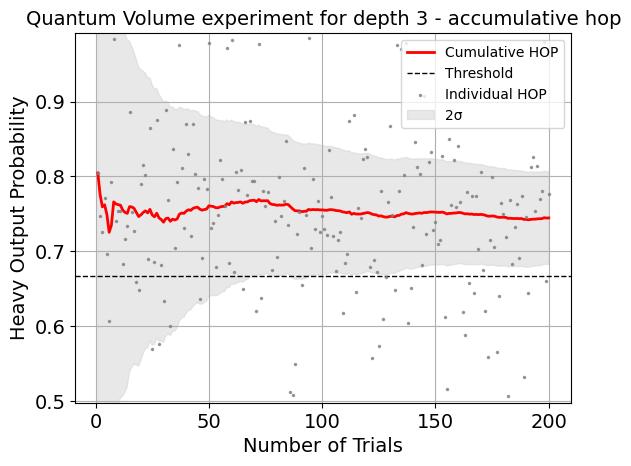

In [216]:
# Plot simple QV test
simple_result.figure(0)

## Determine QV of a device by running QV tests of varying depth 

Now, let us determine the QV of a device by running QV of multiple circuit depths. We will start with smaller circuits and proceed to larger circuits if the tests succeed. The last successful test determines the QV.  

### Define disjoint layouts for depths d = [3,4,5,...,9]

Option 1 (recommended): Uses the layer fidelity benchmark to locate good (and linear) device regions of a certain length. It then splits up these regions into multiple disjoint layouts.

In [270]:
import qiskit_device_benchmarking.utilities.layer_fidelity_utils as lu

separation = 3 # qubit separation between disjoint layouts

# QV of 2^2
length = 2*3 # 4*3
qchain = lu.get_lf_chain(backend, length + separation*2)
layouts2 = [qchain[0:int(length/3)], qchain[int(length/3)+separation:int(2*length/3)+separation], qchain[int(2*length/3)+2*separation:]]

# QV of 2^3
length = 3*3 # 4*3
qchain = lu.get_lf_chain(backend, length + separation*2)
layouts3 = [qchain[0:int(length/3)], qchain[int(length/3)+separation:int(2*length/3)+separation], qchain[int(2*length/3)+2*separation:]]

# QV of 2^4
length = 4*3 # 4*3
qchain = lu.get_lf_chain(backend, length + separation*2)
layouts4 = [qchain[0:int(length/3)], qchain[int(length/3)+separation:int(2*length/3)+separation], qchain[int(2*length/3)+2*separation:]]

# QV of 2^5
length = 5*3  # 5*3
qchain = lu.get_lf_chain(backend, length + separation*2)
layouts5 = [qchain[0:int(length/3)], qchain[int(length/3)+separation:int(2*length/3)+separation], qchain[int(2*length/3)+2*separation:]]

# QV of 2^6
length = 6*3 # 6*3
qchain = lu.get_lf_chain(backend, length + separation*2)
layouts6 = [qchain[0:int(length/3)], qchain[int(length/3)+separation:int(2*length/3)+separation], qchain[int(2*length/3)+2*separation:]]

# QV of 2^7
length = 7*3 # 7*3
qchain = lu.get_lf_chain(backend, length + separation*2)
layouts7 = [qchain[0:int(length/3)], qchain[int(length/3)+separation:int(2*length/3)+separation], qchain[int(2*length/3)+2*separation:]]

# QV of 2^8
length = 8*3 # 8*3
qchain = lu.get_lf_chain(backend, length + separation*2)
layouts8 = [qchain[0:int(length/3)], qchain[int(length/3)+separation:int(2*length/3)+separation], qchain[int(2*length/3)+2*separation:]]

# QV of 2^9
length = 9*3 # 9*3
qchain = lu.get_lf_chain(backend, length + separation*2)
layouts9 = [qchain[0:int(length/3)], qchain[int(length/3)+separation:int(2*length/3)+separation], qchain[int(2*length/3)+2*separation:]]

# Combine layouts
all_layouts = [layouts2, layouts3, layouts4, layouts5, layouts6, layouts7, layouts8, layouts9]

In [271]:
# Make sure layouts are disjoint and are separated by some number of qubits (default is 3)
print(layouts5)
print(layouts7)

[[75, 90, 94, 95, 96], [116, 117, 118, 119, 120], [124, 125, 126, 112, 108]]
[[70, 74, 89, 88, 87, 93, 106], [126, 125, 124, 123, 122, 121, 120], [116, 115, 114, 109, 96, 95, 94]]


Option 2: Uses hardcoded disjoint layouts for all varying depths.

In [272]:
# This is hardcoded for now, but feel free to rewrite with any device region

# layouts2 = [[119, 120],[123, 124]]
# layouts3 = [[119, 120, 121],[123, 124, 125]]
# layouts4 = [[112, 126, 125, 124], [123, 122, 121, 120], [119, 118, 110, 100]]
# layouts5 = [[108, 112, 126, 125, 124], [123, 122, 121, 120, 119], [118, 110, 100, 99, 98]]
# layouts6 = [[94, 95, 96, 109, 114, 115],
#              [116, 117, 118, 119, 120, 121],
#              [122, 123, 124, 125, 126, 112]]
# layouts7 = [[75, 90, 94, 95, 96, 109, 114],
#              [115, 116, 117, 118, 119, 120, 121],
#              [122, 123, 124, 125, 126, 112, 108]]

# layouts8 = [[87, 93, 106, 107, 108, 112, 126, 125],
#              [124, 123, 122, 121, 120, 119, 118, 117],
#              [116, 115, 114, 109, 96, 95, 94, 90]]
# layouts9 = [[70, 74, 89, 88, 87, 93, 106, 107, 108],
#              [112, 126, 125, 124, 123, 122, 121, 120, 119],
#              [118, 117, 116, 115, 114, 109, 96, 95, 94]]

# # Combine layouts
# all_layouts = [layouts4, layouts5, layouts6, layouts7, layouts8, layouts9]

### Initialize Parallel Experiment instances for all d depths
Each depth i has multiple disjoint i-qubit layouts

In [273]:
# Initialize Parallel Experiment instances from Quantum Volume experiments
parallel_exps = []
for layouts in all_layouts:
    exps = []
    for layout in layouts:
        exps.append(QuantumVolume(physical_qubits=layout,
                              backend=backend,
                              trials=200))
    parallel_exp = ParallelExperiment(exps, backend, flatten_results=False)
    parallel_exps.append(parallel_exp)

### Run parallel QV experiments and extract results 
This runs all disjoint layouts of the same depth in parallel. The resulting object is a list of parallel experiment results (total length = max depth), where each parallel experiment contains all disjoint layouts of a certain depth i.

This will take a while (several minutes)

In [274]:
parallel_results = []
maxQV = 1
prev_maxQV = maxQV

# Run parallel experiments on disjoint layouts and update QV until all layouts fail the QV test
for i, parallelexp in enumerate(parallel_exps):
    print('Running parallel experiment', i+1)
    # Run experiments for all n-qubit layouts and extract analysis
    parralel_res = parallelexp.run()
    parralel_res.block_for_results() # this function takes a while depending on the queue on the IBM device
    parallel_results.append(parralel_res)

    # Update QV if any of the experiments were successful
    for i, sub_exp in enumerate(parralel_res.child_data()):
        if len(sub_exp.analysis_results(dataframe=True)):
            qv = sub_exp.analysis_results("quantum_volume",dataframe=True).value.iloc[0]
            if qv > maxQV:
                maxQV = qv
                print('Achieved QV', maxQV)
            
    # Stop running experiments if all n-qubit layouts failed the current QV test
    if prev_maxQV == maxQV:
        break

    prev_maxQV = maxQV

Running parallel experiment 1
Achieved QV 4
Running parallel experiment 2
Achieved QV 8
Running parallel experiment 3


In [275]:
# Print maxQV value
print('QV achieved: ', maxQV)

QV achieved:  8


### Plot QV tests for all d depths

,name,experiment,components,value,quality,backend,run_time,HOPs,two_sigma,depth,trials,success,confidence
09ebac32,mean_HOP,QuantumVolume,"[Q112, Q126]",0.760+/-0.030,good,ibm_sherbrooke,None,"[0.634033203125, 0.717529296875, 0.58447265625...",0.060381,2,200,None,None
a2aece8c,quantum_volume,QuantumVolume,"[Q112, Q126]",4,good,ibm_sherbrooke,None,None,None,2,200,True,0.999027


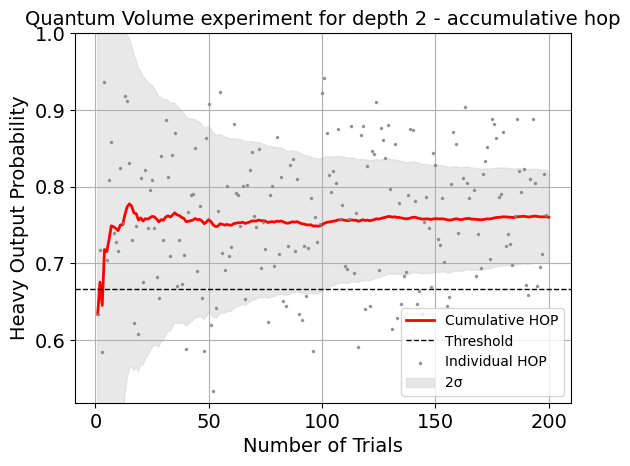

,name,experiment,components,value,quality,backend,run_time,HOPs,two_sigma,depth,trials,success,confidence
5084c07a,mean_HOP,QuantumVolume,"[Q108, Q112, Q126]",0.739+/-0.031,good,ibm_sherbrooke,None,"[0.784423828125, 0.789794921875, 0.73754882812...",0.062073,3,200,None,None
0b05f69b,quantum_volume,QuantumVolume,"[Q108, Q112, Q126]",8,good,ibm_sherbrooke,None,None,None,3,200,True,0.990504


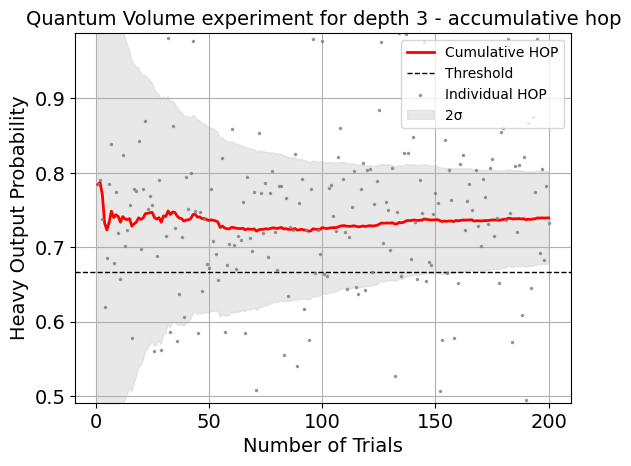

,name,experiment,components,value,quality,backend,run_time,HOPs,two_sigma,depth,trials,success,confidence
06a0db3e,mean_HOP,QuantumVolume,"[Q94, Q95, Q96, Q109]",0.682+/-0.033,bad,ibm_sherbrooke,None,"[0.705322265625, 0.740966796875, 0.68627929687...",0.065885,4,200,None,None
1611e0ab,quantum_volume,QuantumVolume,"[Q94, Q95, Q96, Q109]",1,bad,ibm_sherbrooke,None,None,None,4,200,False,0.674324


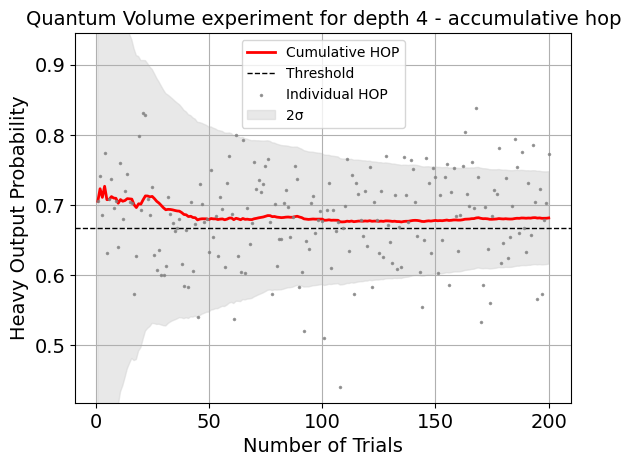

In [276]:
# Plot one QV test per depth
for res in parallel_results: 
    best_res = res.child_data()[0]
    best_qv = best_res.analysis_results("quantum_volume",dataframe=True).value.iloc[0]
    
    for i, sub_exp in enumerate(res.child_data()):
        qv = sub_exp.analysis_results("quantum_volume",dataframe=True).value.iloc[0]
        if qv > best_qv:
            best_res = sub_exp
            best_qv = qv
            
    display(best_res.analysis_results(dataframe=True))
    display(best_res.figure(0))

## Plot layout(s)

In [278]:
from qiskit_device_benchmarking.utilities.gate_map import plot_gate_map

def plot_layout(layout, backend, color='crimson'): 
    qcolors = [color if i in layout else 'silver' for i in range(0, backend.configuration().n_qubits)]
    plot_gate_map(backend, label_qubits=True, qubit_color=qcolors)
    

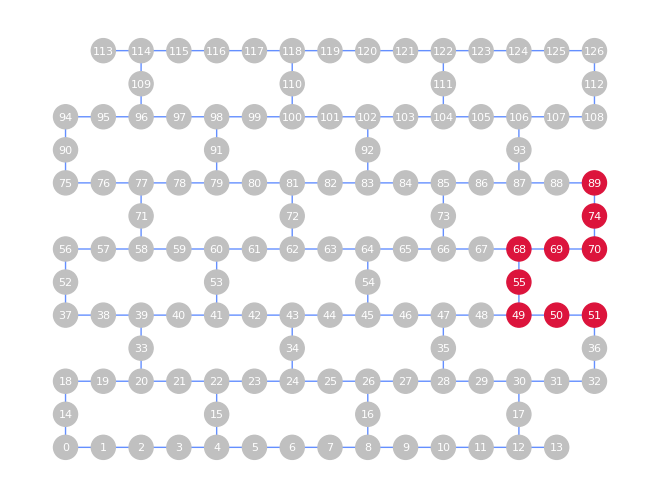

In [285]:
plot_layout(layouts9[0], backend, color='crimson')